In [1]:
import os
IS_COLAB = not os.path.exists("hmm")

if IS_COLAB:
    !git clone https://github.com/mlss-2019/tutorials.git
    !mv tutorials/speech/* .
    !pip install -q simplejson soundfile

# Speech tutorial:  Overview
-------------------------------------------------
- This tutorial includes a bit of signal processing (Part 1) and a couple of simple speech recognizers, both HMM-based (Part 2) and neural (RNN-based, Part 3).
- The tutorial is rather open-ended.  It provides running code and allows you to choose what aspects you find interesting to tinker with.  The 3 parts are independent.
- It is probably not possible to explore in-depth all 3 parts during the time allotted.  I suggest running through everything, then picking one or two things you'd like to explore further.
- If you mainly care about recent research practice, focus on Part 3.  If you want to learn more about speech as a signal, focus on Part 1.  If you want to get some practice with HMMs, focus on Part 2.
- Acknowledgement:  The tutorial is heavily based on exercises created by Shane Settle for TTIC's speech processing course.

# Part 1: A bit of signal processing
-------------------------------------------------
- This part is intended to give a sense of what speech signals "look" like and what a speech recognizer sees at its input.  First run through all of the code.  Then, if you want to do a deep dive, you can spend a good chunk of time on the "things to do" below; otherwise, just move on to Part 2.
- This part takes a single speech signal (waveform) and runs it through a classic feature extraction pipeline that computes mel frequency cepstral coefficients (MFCCs).
- Human-engineered features like MFCCs are still useful for small-data settings, but are no longer commonly used in large-scale speech systems.  
- For our purposes in this tutorial, computing MFCCs also allows us to quickly experiment with different sizes of feature vectors and try to understand how large a representation we really need for speech.
- Note:  This is a machine learning summer school and not a signal processing summer school.  You are not expected to understand every detail in this part, but if things really don't make sense, please ask questions!

### Things to try:
-----------
- As you run through the steps, see if you can figure out why things sound/look as they do.
- How does the recovered signal at the end compare to the original recording?  Any idea why it sounds that way?
- Re-run with smaller numbers of feature dimensions by lowering 'ncoeffs'. What's the smallest number such that the re-synthesized utterance is still intelligible?
- Play with the different settings of <em>size</em> (window size), <em>step</em> (window shift), <em>nfilters</em> (the number of filters), and <em>ncoeffs</em> and observe their effect on the visualizations. Note that the process for inversion can be fragile, so it is best to try powers of 2 (e.g. <em>size</em> = [64, 128, 256, 512, 1024, ...] and <em>step</em> = [8, 16, 32, 64, 128, ...]).  If you've gotten this far and some of the signal processing is making sense (or you already knew some signal processing), see if you can figure out what values of these parameters make sense for speech recognition.


In [2]:
# Some setup
%matplotlib inline
import matplotlib.pyplot as plt
PLOT_CONFIG = { 'interpolation': "nearest", 'aspect': "auto", 'cmap': "Greys" }

from IPython.display import Audio

import soundfile as sf
import numpy as np

from numpy.fft import fft, ifft
from scipy.fftpack import dct, idct

from collections import defaultdict
from copy import deepcopy
from glob import glob

In [3]:
# The main signal processing functions we will use

def pre_emphasis(x):
    """
    Applies pre-emphasis to the signal:  Balances the spectrum by increasing the 
    amplitudes of high-frequency components and decreasing the amplitudes of 
    lower-frequency components (much like turning up the treble and turning
    down the bass)
    ------
    :in:
    x, array of samples
    ------
    :out:
    y, array of samples
    """
    y = np.append(x[0], x[1:] - 0.97 * x[:-1])
    
    return y
    
def hamming(n):
    """
    Hamming window for weighting samples within an analysis window.
    ------
    :in: 
    n, window size
    ------
    :out: 
    win, array of weights to apply along window
    """
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(n) / (n - 1))
    
    return win
    
def windowing(x, size, step):
    """
    Window and stack signal into overlapping frames.
    ------
    :in:
    x, array of samples
    size, window size in number of samples (Note: this should be a power of 2)
    step, window shift in number of samples
    ------
    :out:
    frames, 2d-array of frames with shape (number of windows, window size)
    """
    xpad = np.append(x, np.zeros((size - len(x) % size)))
    
    T = (len(xpad) - size) // step
    frames = np.stack([xpad[t * step:t * step + size] for t in range(T)])
    
    return frames
    
def discrete_fourier_transform(x):
    """
    Compute the discrete fourier transform for each frame of windowed signal x.
    Typically, we talk about performing the DFT on short-time windows
    (often referred to as the Short-Time Fourier Transform). Here, the input
    is a 2d-array with shape (window size,  number of windows). We want to
    perform the DFT on each of these windows.
    --------
    :in: 
    x, 2d-array of frames with shape (window size, number of windows)
    --------
    :out:
    X, 2d-array of complex spectrum after DFT applied to each window of x
    """
    
    n = len(x)
    indices = np.arange(n)
    M = np.exp(-2j * np.pi * np.outer(indices, indices) / n)
    return np.dot(M, x)

    
def fast_fourier_transform(x):
    """
    Fast-fourier transform. Efficient algorithm for computing the DFT.
    --------
    :in: 
    x, 2d-array of frames with shape (window size, number of windows)
    --------
    :out:
    X, 2d-array of complex spectrum after DFT applied to each window of x
    """
    fft_size = len(x)

    if fft_size <= 16:
        X = discrete_fourier_transform(x)
    
    else:
        indices = np.arange(fft_size)
        even = fast_fourier_transform(x[::2])
        odd = fast_fourier_transform(x[1::2])
        m = np.exp(-2j * np.pi * indices / fft_size).reshape(-1, 1)
        X = np.concatenate([even + m[:fft_size // 2] * odd, even + m[fft_size // 2:] * odd])
    
    return X


def mel_filterbank(nfilters, fft_size, sample_rate):
    """
    A set of filters that warps the speech spectrum in a similar way to the human ear.
    --------
    :in: 
    nfilters, number of filters
    fft_size, window size over which fft is performed
    sample_rate, sampling rate of the signal
    --------
    :out:
    mel_filter, 2d-array of (fft_size / 2, nfilters) 
    mel_inv_filter, 2d-array of (nfilters, fft_size / 2) used to invert later
    melpoints, 1d-array of frequencies converted to the mel scale
    """
    freq2mel = lambda f: 2595. * np.log10(1 + f / 700.)
    mel2freq = lambda m: 700. * (10**(m / 2595.) - 1)

    lowfreq = 0
    highfreq = sample_rate // 2

    lowmel = freq2mel(lowfreq)
    highmel = freq2mel(highfreq)

    melpoints = np.linspace(lowmel, highmel, 1 + nfilters + 1)

    # convert from freq to fft bin number
    fft_bins = ((fft_size + 1) * mel2freq(melpoints) // sample_rate).astype(np.int32)

    filterbank = np.zeros((nfilters, fft_size // 2))
    for j in range(nfilters):
        for i in range(fft_bins[j], fft_bins[j + 1]):
            filterbank[j, i] = (i - fft_bins[j]) / (fft_bins[j + 1] - fft_bins[j])
        for i in range(fft_bins[j + 1], fft_bins[j + 2]):
            filterbank[j, i] = (fft_bins[j + 2] - i) / (fft_bins[j + 2] - fft_bins[j + 1])

    mel_filter = filterbank.T / filterbank.sum(axis=1).clip(1e-16)
    mel_inv_filter = filterbank

    return mel_filter, mel_inv_filter, melpoints
    
    
def inv_spectrogram(X_s, size, step, n_iter=15):
    """
    Invert from a spectrogram back to an audible waveform.
    """
    
    def find_offset(a, b):
        corrs = np.convolve(a - a.mean(), b[::-1] - b.mean())
        corrs[:len(b) // 2] = -1e12
        corrs[-len(b) // 2:] = -1e12
        return corrs.argmax() - len(a)

    def iterate(X, iteration):
        T, n = X.shape
        size = n // 2

        x = np.zeros((T * step + size))
        window_sum = np.zeros((T * step + size))

        est_start = size // 2 - 1
        est_stop = est_start + size

        for t in range(T):
            x_start = t * step
            x_stop = x_start + size

            est = ifft(X[t].real + 0j if iteration == 0 else X[t]).real[::-1]            
            if t > 0 and x_stop - step > x_start and est_stop - step > est_start:
                offset = find_offset(x[x_start:x_stop - step], est[est_start:est_stop - step])
            else:
                offset = 0
                
            x[x_start:x_stop] += est[est_start - offset:est_stop - offset] * hamming(size)
            window_sum[x_start:x_stop] += hamming(size)

        return x.real / window_sum.clip(1e-12)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    reg = np.max(X_s) / 1e8

    X_best = iterate(deepcopy(X_s), 0)
    for i in range(1, n_iter):
        X_best = windowing(X_best, size, step) * hamming(size)
        est = fast_fourier_transform(X_best.T).T
        phase = est / np.maximum(reg, np.abs(est))
        X_best = iterate(X_s * phase[:len(X_s)], i)
    
    return np.real(X_best)

In [4]:
# Load the speech signal (waveform)
signal, fs = sf.read("aurora_FMS_15739A.wav")
Audio(data=signal, rate=fs)

In [5]:
# Pre-emphasize the signal
Audio(data=pre_emphasis(signal), rate=fs)

In [6]:
# Just for fun, confirm how much faster the fast Fourier transform is than a 
# naive discrete Fourier transform.  This cell should take a minute or so to run.

print("\nWindow size = 128")
frames128 = windowing(signal, 128, 64) * hamming(128)
print("Timing vanilla DFT")
%timeit -n 50 discrete_fourier_transform(frames128.T).T
print("Timing FFT")
%timeit -n 50 fast_fourier_transform(frames128.T).T

print("\nWindow size = 512")
frames512 = windowing(signal, 512, 256) * hamming(512)
print("Timing vanilla DFT")
%timeit -n 50 discrete_fourier_transform(frames512.T).T
print("Timing FFT")
%timeit -n 50 fast_fourier_transform(frames512.T).T

print("\nWindow size = 1024")
frames1024 = windowing(signal, 1024, 512) * hamming(1024)
print("Timing vanilla DFT")
%timeit -n 50 discrete_fourier_transform(frames1024.T).T
print("Timing FFT")
%timeit -n 50 fast_fourier_transform(frames1024.T).T


Window size = 128
Timing vanilla DFT
1.51 ms ± 793 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
Timing FFT
The slowest run took 5.97 times longer than the fastest. This could mean that an intermediate result is being cached.
3.81 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)

Window size = 512
Timing vanilla DFT
17.8 ms ± 7.23 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)
Timing FFT
3.67 ms ± 323 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)

Window size = 1024
Timing vanilla DFT
56.7 ms ± 4.98 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)
Timing FFT
7.24 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


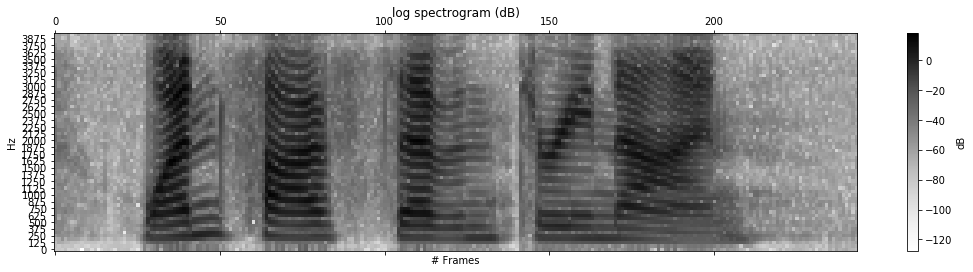

In [7]:
# Compute the spectrogram of the signal

# Set some parameters
size = 128 # window size for the FFT
step = size // 2 # time between consecutive windows
nfilters = 26 # number of mel frequency channels
ncoeffs = 13 # number of feature dimensions (MFCCs) to keep

# Pre-emphasize
pre_emphasized_signal = pre_emphasis(signal)

# Window the signal
frames = windowing(pre_emphasized_signal, size, step) * hamming(size)

# Compute the (complex) spectrum
spectrum = fast_fourier_transform(frames.T).T
spectrum = spectrum[:, :size // 2] # only need to keep half since it's symmetric

# Compute the spectrum magnitude (this is typically what is meant by "spectrogram")
magnitude = np.abs(spectrum)

# Get the spectrum power
power = magnitude**2 / size

# Visualize log spectrogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,4))
cax = ax.matshow(20*np.log10(magnitude.clip(1e-12)).T, origin='lower', **PLOT_CONFIG)
fig.colorbar(cax, label='dB')
plt.title('log spectrogram (dB)')
plt.xlabel('# Frames')
plt.ylabel('Hz')
ixs = np.arange(0, size // 2, 2)
freqs = ixs * fs // size
plt.yticks(ixs, freqs);

In [8]:
# Warp the spectrogram frequency axis (to the "mel frequency scale") and run the 
# spectrogram through a set of filters, so as to mimic (very roughly) what the 
# human ear does

# Generate the mel filters and mel inverse filters
mel_filter, mel_inv_filter, melpoints = mel_filterbank(nfilters, size, fs)

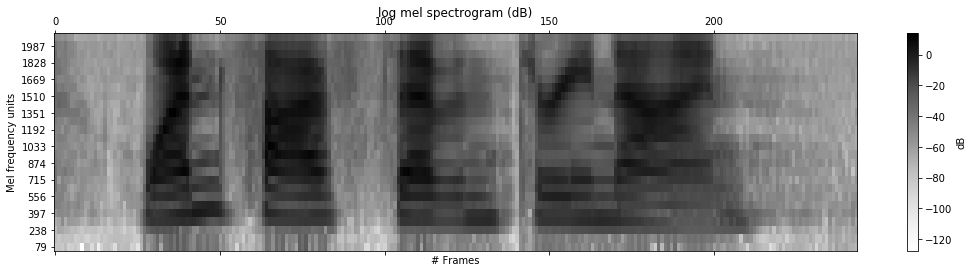

In [9]:
# Visualize the warped spectrogram (often called a "log mel spectrogram")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,4))
cax = ax.matshow(20*np.log10(magnitude.dot(mel_filter).clip(1e-16)).T, origin='lower', **PLOT_CONFIG)
fig.colorbar(cax, label='dB')
plt.title('log mel spectrogram (dB)')
plt.xlabel('# Frames')
plt.ylabel('Mel frequency units')
ixs = np.arange(0, nfilters, 2)
plt.yticks(ixs, map(int, melpoints[1::2]));


Text(0.5,1.05,'MFCCs')

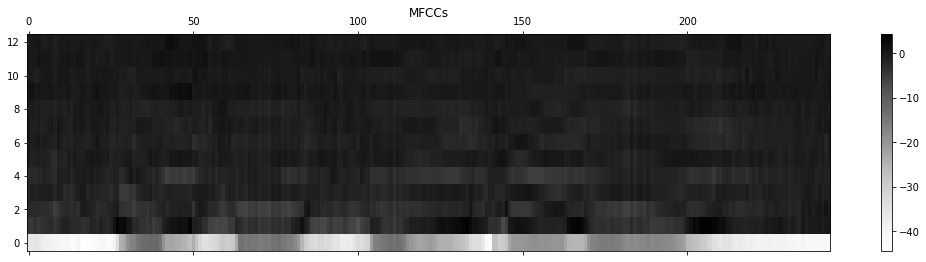

In [10]:
# Finally, compute the feature vectors (MFCCs)

# Apply mel warping filters to power spectrum and take log10
log_mel_fbank = np.log10(power.dot(mel_filter).clip(1e-16))

# Compute MFCCs using discrete cosine transform (DCT)
"""
Note: similarly to the DFT, the DCT is used to decompose a finite discrete-time 
vector into a sum of scaled and shifted (real-valued) cosine functions
"""
mfccs = dct(log_mel_fbank, type=2, axis=1, norm='ortho')

# Keep a subset of the feature dimensions (cepstral coefficients)
mfccs = mfccs[:,:ncoeffs]

# Visualize the MFCCs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,4))
cax = ax.matshow(mfccs.T, origin='lower', **PLOT_CONFIG)
fig.colorbar(cax)
plt.title('MFCCs')

In [11]:
# Invert the whole process and listen to the reconstructed speech, to get a  
# sense of what information we have retained or lost in this representation.

# Invert from MFCCs back to waveform, starting with inverting the DCT
recovered_log_mel_fbank = idct(mfccs, type=2, n=nfilters, axis=1, norm='ortho')

# Exponentiate log and invert mel warping
recovered_power = (10**recovered_log_mel_fbank).dot(mel_inv_filter)

# Invert mel warping of spectrogram
recovered_magnitude = np.sqrt(recovered_power * size)

# Finally invert the spectrogram to get back a waveform
recovered_signal = inv_spectrogram(recovered_magnitude, size, step)
Audio(data=recovered_signal, rate=fs)  

# (Note: we have not inverted the preemphasis, so we are hearing a bit more of 
# the higher and less of the lower frequencies)

/Users/nickpawlowski/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


# Part 2: Recognizing 2-digit numbers with HMMs
-------------------------------------------------
- In this part you will train and test a simple hidden Markov model-based speech recognizer that recognizes 1- or 2-digit numbers.  
- Each word is a digit in the range 0-9, where 0 is pronounced "oh" (not "zero").
- Each word is modeled as a separate HMM, with the same number of states for each word.
- The observation distribution is a single Gaussian in each state.
- (We are doing a very simple recognition task, using very simple models, so that we can get reasonable performance within the time span of the tutorial.)

### Things to do:
-----------
- Run through the steps and make sure things are making sense.
- Experiment with different values for the number of states in the single-digit model.
- Try changing other aspects: parameter initialization, convergence criteria, HMM structure, or any other aspect that you find interesting.
- See if you can improve the word error rate through such changes.
- Note that there is no separate development (tuning) set, just a train set and a test set.  So for purposes of this exercise, we are tuning on the test set (the horror!)

In [14]:
# Some setup

import numpy as np
import pickle as pkl
import time
import json
import random
import torch
from torch import nn
import editdistance
import os
np.seterr(divide='ignore') # masks log(0) errors
from hmm.multiple import FullGaussianHMM
from hmm.single import GaussianHMM

In [15]:
"""
Single-digit HMM recognizer
"""
data_single_digit = np.load("hmm/data/mfccs_single.npz", allow_pickle=True)

n_states = 15  # number of states per word
n_dims = 13  # number feature dimensions per input frame
n_iter = 1  # single iteration
model = dict()
digits = range(10)
    
# Training
for digit in digits:
    print("Training HMM for digit %d" % digit)
    Xtrain_digit = [x for x, y in zip(data_single_digit["Xtrain"], data_single_digit["Ytrain"]) if y == digit]
    model[digit] = GaussianHMM(n_states=n_states, n_dims=n_dims)
    model[digit].init_gaussian_params(Xtrain_digit)
    model[digit].init_hmm_params()
    
    # Run Baum-Welch (EM) training
    for i in range(n_iter):
        print("starting iteration {}...".format(i+1))
        model[digit].train(Xtrain_digit)

# Testing
print("\nTesting...")
accuracy = np.zeros(10)
confusion = np.zeros((10, 10))
for x, y in zip(data_single_digit["Xtest"], data_single_digit["Ytest"]):
    T = len(x)

    # Since this is single-word recognition, we will simply score the
    # observed input with each HMM, and pick the one with the highest score.
    # We could use the forward, backward, or Viterbi algorithm for scoring;
    # here we are using Viterbi.
    scores = []
    for digit in digits:
        log_pi = np.log(model[digit].pi)
        log_A = np.log(model[digit].A)
        log_B = model[digit].get_emissions(x)
        _, log_prob = model[digit].viterbi(log_pi, log_A, log_B)
        scores.append(log_prob)

    top_digit, top_log_prob = sorted(zip(digits, scores), key=lambda x: -x[1])[0]
    confusion[y, top_digit] += 1.

accuracy = np.diag(confusion) / confusion.sum(axis=1)
wer = 100*(1-accuracy)

print("Overall error rate:  {:.2f}\nPer-digit error rates: {}".format(wer.mean(), wer))

# Save the model
with open("hmm/single_digit_model.pkl", "wb") as f:
    pkl.dump(model, f)

Training HMM for digit 0
starting iteration 1...
Training HMM for digit 1
starting iteration 1...
Training HMM for digit 2
starting iteration 1...
Training HMM for digit 3
starting iteration 1...
Training HMM for digit 4
starting iteration 1...
Training HMM for digit 5
starting iteration 1...
Training HMM for digit 6
starting iteration 1...
Training HMM for digit 7
starting iteration 1...
Training HMM for digit 8
starting iteration 1...
Training HMM for digit 9
starting iteration 1...

Testing...
Overall error rate:  0.42
Per-digit error rates: [0.         0.         0.         0.         4.16666667 0.
 0.         0.         0.         0.        ]


### Well that was easy. 
-----------
- Almost 100% accuracy.
- Let's see how things go when we move to 2-digit sequences.


In [23]:
"""
Multiple-digit HMM recognizer
"""
data_multiple_digit = np.load("hmm/data/mfccs_multiple.npz", allow_pickle=True)

# Initialize the model with the parameters from the single-digit recognizer.
full_model = FullGaussianHMM(data_multiple_digit["Xtrain"], "hmm/single_digit_model.pkl")

n_iter = 1

# Train
print("Training HMM")
for i in range(n_iter):
    print("starting iteration {}...".format(i + 1))
    full_model.train(data_multiple_digit["Xtrain"], data_multiple_digit["Ytrain"])

# Test
print("Testing HMM")
test_wer = full_model.test(data_multiple_digit["Xtest"], data_multiple_digit["Ytest"])
print("{:.2f}% word error rate".format(test_wer * 100.))

Training HMM
starting iteration 1...
50 examples...
100 examples...
150 examples...
200 examples...
250 examples...
300 examples...
350 examples...
400 examples...
450 examples...
500 examples...
Testing HMM
34.16% word error rate


# Part 3: Recognizing 2-digit numbers with RNNs + attention
-------------------------------------------------
- In this part you will train and test a simple end-to-end LSTM-based attention model that recognizes 2-digit numbers.  

### Things to do:
-----------
- Run through the steps and make sure things are making sense.
- Try implementing a different type of attention model, and/or tuning hyperparamters (see config.json):
  - hidden state size
  - num layers
  - learning rate
  - batch size
  - dropout (applied between LSTM layers)
  - sampling prob (for scheduled sampling) 
  - or any other aspect you find interesting
- Note: We didn't cover scheduled sampling in lecture (though perhaps previous lectures have covered it) but it
refers to decoding during training time. At each time step, a new prediction is made (in this case one of 0-9).  With scheduled sampling, we feed this previous prediction as the input to the next step of the
decoder with probability sample_prob; otherwise the ground truth is used. If the sample_prob is set to
0, then the ground truth is always fed as input at each timestep.

- To get a better understanding of the model's behavior, try plotting some things.  For example:
  - The loss and word error rate (WER) vs. time on train and dev.
  - For several models trained with a range of scheduled sampling rates, plot sampling rate vs. loss and WER.


In [17]:
# Some setup
from rnn.loader import make_loader, Preprocessor
from rnn.model import Seq2Seq
from rnn.model import LinearND #Hint: this is useful when defining the modified attention mechanism

In [18]:
# Define the attention component of the model (included here to make it easy to modify)

import torch
from torch import nn

class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim, attn_dim=None):
        """
        Initialize Attention.
        ----
        enc_dim: encoder hidden state dimension
        dec_dim: decoder hidden state dimension
        attn_dim: attention feature dimension
        """
        super(Attention, self).__init__()
        if enc_dim == dec_dim and attn_dim is None:
            self.use_default = True
        elif attn_dim is not None:
            self.use_default = False
            self.attn_dim = attn_dim
            self.enc_dim = enc_dim
            self.dec_dim = dec_dim
            self.v = LinearND(self.attn_dim, 1, bias=False)
            self.W1 = LinearND(self.enc_dim, self.attn_dim, bias=False)
            self.W2 = nn.Linear(self.dec_dim, self.attn_dim, bias=False)
        else:
            raise ValueError("invalid args (enc_dim={}, dec_dim={}, attn_dim={})".format(enc_dim, dec_dim, attn_dim))

    def forward(self, eh, dhx, ax=None):
        """
        Forward Attention method.
        ----
        eh (FloatTensor): the encoder hidden state with
            shape (batch size, time, hidden dimension).
        dhx (FloatTensor): one time step of the decoder hidden
            state with shape (batch size, hidden dimension).
        ax (FloatTensor): one time step of the attention vector.
        ----
        Returns the context vectors (sx) and the corresponding attention alignment (ax)
        """
        
        # Compute inner product of decoder slice with every encoder slice
        pax = torch.sum(eh * dhx, dim=2)
        ax = nn.functional.softmax(pax, dim=1)
        sx = torch.sum(eh * ax.unsqueeze(2), dim=1, keepdim=True)

        return sx, ax

In [19]:
# Training and testing functions

def compute_wer(results):
    """
    Compute the word-error-rate (WER).
    """
    dist = 0.
    for label, pred in results:
        dist += editdistance.eval(label, pred)
    total = sum(len(label) for label, _ in results)
    return dist / total

def train(model, optimizer, ldr):
    """
    Train the model for an epoch (one pass over the training data)
    ----
    model: Seq2Seq model instance
    optimizer: torch.nn optimizer instance
    ldr: data loader instance
    ----
    Returns the average loss over an epoch
    """
    model.train()
    model.scheduled_sampling = model.sample_prob != 0
    
    losses = []
    
    for ii, (inputs, labels) in enumerate(ldr):
        optimizer.zero_grad()
        x, y = model.collate(inputs, labels)
        loss = model.loss(x, y)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        losses.append(loss.data.item())
        
    return np.mean(losses)

def evaluate(model, ldr, preproc):
    """
    Evaluate the model (on either dev or test).
    ----
    model: Seq2Seq model instance
    ldr: data loader instance
    preproc: preprocessor instance
    ----
    Returns the average loss and wer on a given dataset
    """
    model.eval()
    model.scheduled_sampling = False
    
    losses, hyps, refs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in ldr:
            x, y = model.collate(inputs, labels)
            # get loss
            loss = model.loss(x, y)
            losses.append(loss.data.item())
            # get predictions
            pred = model.infer(x, y)
            hyps.extend(pred)
            refs.extend(labels)

    results = [(preproc.decode(r), preproc.decode(h)) for r, h in zip(refs, hyps)]
    
    return np.mean(losses), compute_wer(results)

In [21]:
# Train and test the attention-based recognizer.  With the default config,
# you should get <10% word error rate within 15 epochs.

import simplejson as json
import random

RNN_CONFIG_PATH = "rnn/config.json"
with open(RNN_CONFIG_PATH, "r") as fid:                                                                                                                                                                                                                                      
    config = json.load(fid)

random.seed(config["seed"])
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.deterministic = True

print("Training RNN")
data_cfg = config["data"]
model_cfg = config["model"]
opt_cfg = config["optimizer"]

preproc = Preprocessor(data_cfg["train_set"], start_and_end=data_cfg["start_and_end"])

train_ldr = make_loader(data_cfg["train_set"], preproc, opt_cfg["batch_size"])
dev_ldr = make_loader(data_cfg["dev_set"], preproc, opt_cfg["batch_size"])

attention = Attention(model_cfg["encoder"]["hidden_size"], model_cfg["decoder"]["hidden_size"])
model = Seq2Seq(preproc.input_dim, preproc.vocab_size, attention, model_cfg)
model = model.cuda() if use_cuda else model.cpu()

optimizer = torch.optim.SGD(model.parameters(), lr=opt_cfg["learning_rate"], momentum=opt_cfg["momentum"])

log="epoch {:4} | train_loss={:6.2f}, dev_loss={:6.2f} with {:6.2f}% WER ({:6.2f}s elapsed)"

best_so_far = float("inf")
for ep in range(opt_cfg["max_epochs"]):
    start = time.time()
    
    train_loss = train(model, optimizer, train_ldr)    
    dev_loss, dev_wer = evaluate(model, dev_ldr, preproc)
    
    print(log.format(ep + 1, train_loss, dev_loss, dev_wer * 100., time.time() - start))
    
    torch.save(model, os.path.join(config["save_path"], str(ep)))
    
    if dev_wer < best_so_far:
        best_so_far = dev_wer
        torch.save(model, os.path.join(config["save_path"], "best"))

Training RNN
epoch    1 | train_loss=  5.47, dev_loss=  4.55 with  77.32% WER ( 10.70s elapsed)


/Users/nickpawlowski/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch    2 | train_loss=  3.95, dev_loss=  3.63 with  63.93% WER ( 10.85s elapsed)
epoch    3 | train_loss=  3.38, dev_loss=  3.27 with  60.36% WER ( 11.64s elapsed)
epoch    4 | train_loss=  2.76, dev_loss=  2.63 with  46.43% WER ( 11.23s elapsed)
epoch    5 | train_loss=  2.15, dev_loss=  2.76 with  48.39% WER ( 12.74s elapsed)
epoch    6 | train_loss=  1.62, dev_loss=  1.52 with  26.79% WER ( 13.27s elapsed)
epoch    7 | train_loss=  1.01, dev_loss=  0.95 with  14.64% WER ( 13.01s elapsed)
epoch    8 | train_loss=  0.77, dev_loss=  1.01 with  18.04% WER ( 12.12s elapsed)
epoch    9 | train_loss=  0.58, dev_loss=  0.73 with  12.32% WER ( 11.98s elapsed)
epoch   10 | train_loss=  1.41, dev_loss=  2.54 with  43.39% WER ( 16.06s elapsed)
epoch   11 | train_loss=  2.03, dev_loss=  2.19 with  34.64% WER ( 13.86s elapsed)
epoch   12 | train_loss=  1.37, dev_loss=  0.81 with  13.57% WER ( 13.73s elapsed)
epoch   13 | train_loss=  0.76, dev_loss=  0.90 with  15.00% WER ( 11.85s elapsed)
epoc

In [22]:
print("Testing RNN")
test_model = torch.load(os.path.join(config["save_path"], "best"))
test_ldr = make_loader(data_cfg["test_set"], preproc, opt_cfg["batch_size"])

_, test_wer = evaluate(test_model, test_ldr, preproc)

print("{:.2f}% WER (test)".format(test_wer * 100.))

Testing RNN
5.71% WER (test)
